#GENERATIVE ADVERSERIAL NETWORKS

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root = 'data', train = True, download = True, transform = Compose([ToTensor(), Normalize(mean = (0.5,), std = (0.5,))]))

In [2]:
img, label = mnist[0]
print('Label:' , label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
  out = (x + 1)/ 2
  return out.clamp(0, 1)

Label: 5


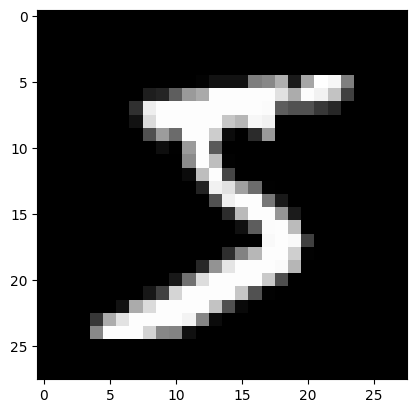

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap = 'gray')
print('Label:' , label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

First batch
torch.Size([100, 1, 28, 28])
tensor([5, 3, 5, 8, 0, 0, 4, 7, 9, 0, 0, 3, 1, 7, 1, 5, 5, 0, 7, 9, 5, 3, 1, 6,
        7, 1, 4, 0, 4, 8, 8, 6, 0, 7, 8, 4, 7, 4, 0, 1, 1, 9, 1, 3, 4, 6, 8, 5,
        3, 1, 4, 2, 9, 2, 8, 1, 3, 2, 8, 0, 2, 8, 7, 6, 0, 4, 9, 8, 4, 8, 7, 4,
        8, 9, 1, 8, 5, 6, 3, 1, 9, 1, 5, 6, 2, 4, 2, 9, 1, 6, 4, 7, 5, 2, 0, 2,
        8, 7, 9, 1])


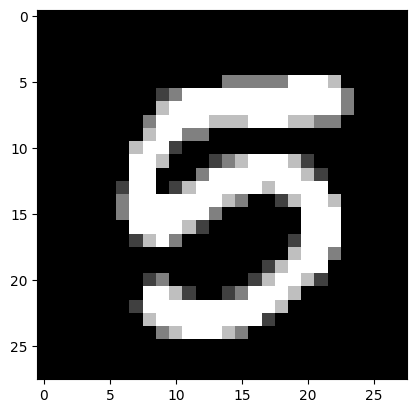

In [6]:
for img_batch, label_batch in data_loader:
  print('First batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0], cmap = 'gray')
  print(label_batch)
  break

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [8]:
image_size = 784
hidden_size = 256

In [9]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [10]:
D.to(device);

In [11]:
latent_size = 64

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())

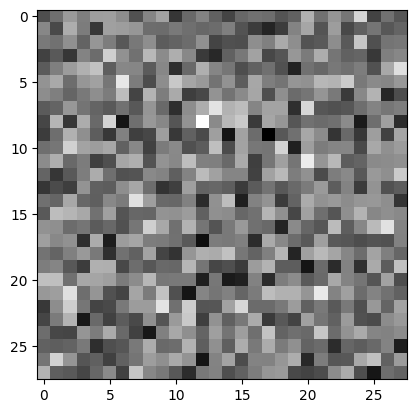

In [14]:
plt.imshow(gen_imgs[0], cmap = 'gray');

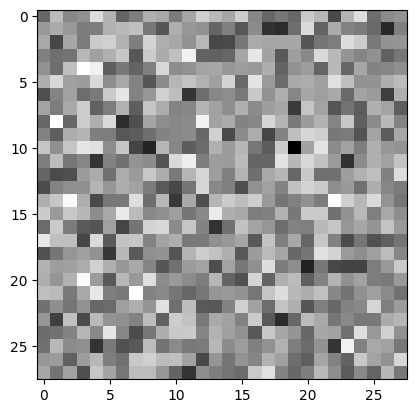

In [15]:
plt.imshow(gen_imgs[1], cmap = 'gray');

In [16]:
G.to(device);

In [17]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [18]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(images):
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  outputs = D(images)
  d_loss_real = criterion(outputs, real_labels)
  real_score = outputs

  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs, fake_labels)
  fake_score = outputs

  d_loss = d_loss_real + d_loss_fake
  reset_grad()

  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [19]:
def train_generator():
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size, 1).to(device)
  g_loss = criterion(D(fake_images), labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

In [20]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

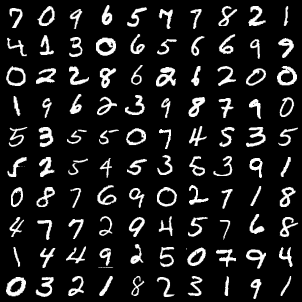

In [21]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
  images = images.reshape(images.size(0), 1, 28, 28)
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow = 10)
  break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


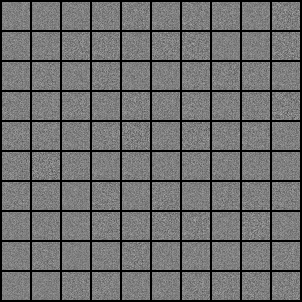

In [22]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vectors)
  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving', fake_fname)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [23]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
  for i, (images, _) in enumerate(data_loader):
    images = images.reshape(batch_size, -1).to(device)

    d_loss, real_score, fake_score = train_discriminator(images)
    g_loss, fake_images = train_generator()

    if (i + 1) % 300 == 0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())

      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

      save_fake_images(epoch+1)

Epoch [0/300], Step [300/600], d_loss: 0.3243, g_loss: 3.0381, D(x): 0.87, D(G(z)): 0.13
Saving fake_images-0001.png
Epoch [0/300], Step [600/600], d_loss: 0.0529, g_loss: 5.4262, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [300/600], d_loss: 0.0626, g_loss: 4.7714, D(x): 0.98, D(G(z)): 0.04
Saving fake_images-0002.png
Epoch [1/300], Step [600/600], d_loss: 0.6516, g_loss: 2.6872, D(x): 0.75, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/300], Step [300/600], d_loss: 0.1998, g_loss: 4.9013, D(x): 0.93, D(G(z)): 0.06
Saving fake_images-0003.png
Epoch [2/300], Step [600/600], d_loss: 0.7665, g_loss: 2.2699, D(x): 0.73, D(G(z)): 0.15
Saving fake_images-0003.png
Epoch [3/300], Step [300/600], d_loss: 0.5859, g_loss: 2.3844, D(x): 0.84, D(G(z)): 0.21
Saving fake_images-0004.png
Epoch [3/300], Step [600/600], d_loss: 0.3530, g_loss: 3.9362, D(x): 0.88, D(G(z)): 0.09
Saving fake_images-0004.png
Epoch [4/300], Step [300/600], d_loss: 0.3631, g_loss: 3.7531, D

In [24]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

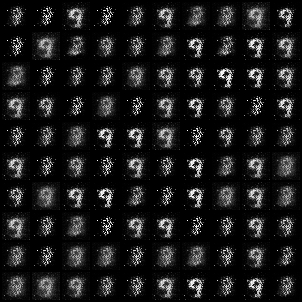

In [25]:
Image('./samples/fake_images-0010.png')

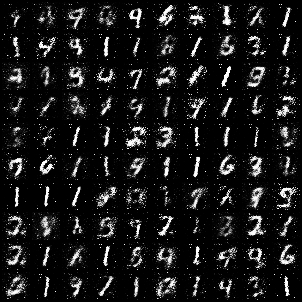

In [26]:
Image('./samples/fake_images-0050.png')

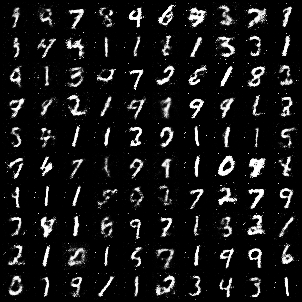

In [27]:
Image('./samples/fake_images-0100.png')

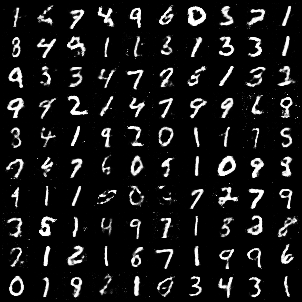

In [28]:
Image('./samples/fake_images-0300.png')

In [29]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.mp4'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302, 302))

[out.write(cv2.imread(fname)) for fname in files]

out.release()
FileLink('gans_training.mp4')

/content/gans_training.mp4

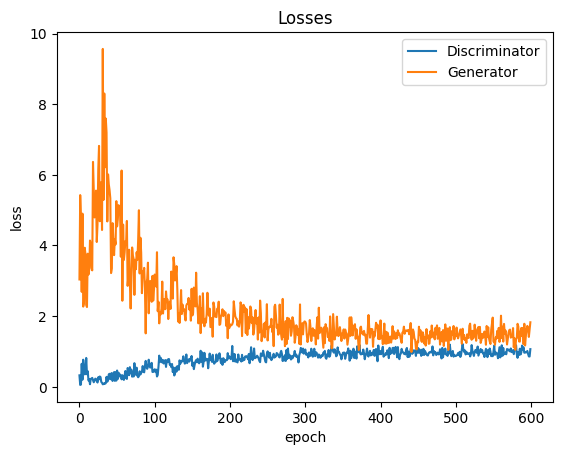

In [30]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

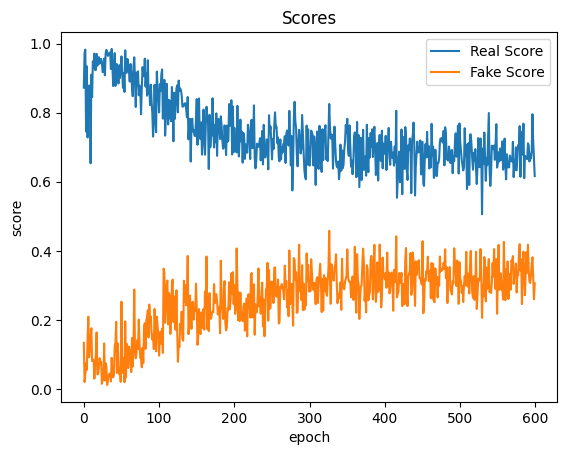

In [31]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake Score'])
plt.title('Scores');